In [1]:
from scipy.sparse import coo_matrix
import numpy as np


def color(J, p=None):
    m, n = J.shape
    if p is None:
        p = np.arange(n)

    J = J[:, p]
    group = np.zeros(n, dtype=int)
    ncol = 0

    while np.any(group == 0):
        ncol += 1
        rows = np.zeros(m)
        index = np.where(group == 0)[0]
        lenindex = len(index)
        for i in range(lenindex):
            k = index[i]
            inner = np.inner(J[:, k].todense().ravel(), rows)
            if inner == 0:
                group[k] = ncol
                rows += J[:, k].toarray().flatten()

    group[p] = group
    return group


In [2]:
from scipy.sparse import coo_matrix
import numpy as np
from numpy.linalg import norm


def sfd(x, grad, H, group, dx):
    xcurr = x.flatten()
    m, n = H.shape
    v = np.zeros(n)
    ncol = np.max(group)

    alpha = np.sqrt(np.finfo(float).eps) * np.ones(ncol)

    H = coo_matrix(H != 0).toarray()  # Equivalent of MATLAB's spones
    for k in range(ncol):
        d = (group == k)
        xnrm = max(norm(xcurr[d]), 1)
        alpha[k] *= xnrm

        y = xcurr + alpha[k] * d
        x[:] = y

        v = dx(x)
        w = (v - grad) / alpha[k]
        cols = np.where(d)[0]
        A = coo_matrix((m, n))
        A[:, cols] = H[:, cols]
        H[:, cols] -= A[:, cols]

        A = coo_matrix((w[A.nonzero()[0]], A.nonzero()), shape=(m, n))
        H += A.toarray()

    H = (H + H.T) / 2  # Make it symmetric
    return H


In [3]:
from scipy.sparse import diags

# create sparse three diagonal matrix
def sparse_tridiagonal(n):
    """Create a three-diagonal CSR matrix with ones on its diagonals.

    Args:
    n: The number of rows (or columns) in the matrix.

    Returns:
    The created matrix as a CSR matrix.
    """
    # Create the diagonals
    diagonals = np.ones((3, n))
    # The main diagonal has offset 0, the diagonals above and below it have offsets -1 and 1, respectively
    offsets = [-1, 0, 1]
    # Use the `diags` function to create a sparse matrix with these diagonals
    matrix = diags(diagonals, offsets, shape=(n, n), format='csr')

    return matrix

from energy import JaxEnergy

In [4]:
p, a, b = 3, -1, 1
ne = 10
jax_energy = JaxEnergy(p, a, b, ne)
f, df, ddf_cls = jax_energy.recompile()
x0 = jax_energy.x0


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [5]:
from scipy.sparse.csgraph import reverse_cuthill_mckee

Hstr = sparse_tridiagonal(ne - 1)


In [39]:
p = reverse_cuthill_mckee(Hstr)
p


array([8, 7, 6, 5, 4, 3, 2, 1, 0], dtype=int32)

In [10]:
from scipy.sparse import csc_matrix


def color(J, p=None):
    '''
    Column partition for sparse finite differences.

    GROUP = COLOR(J,P) returns a partition of the 
    column corresponding to a coloring of the column-
    intersection graph. GROUP(I) = J means column I is 
    colored J.

    All columns belonging to a color can be estimated 
    in a single finite difference.
    '''
    m, n = J.shape
    if p is None:
        p = np.arange(n)

    J = csc_matrix(J[:, p])
    group = np.zeros(n, dtype=int)
    ncol = 0
    J = (J != 0).astype(int)  # equivalent to spones(J) in MATLAB

    while np.any(group == 0):
        # Build group for ncol
        ncol += 1
        rows = np.zeros(m, dtype=int)
        index = np.where(group == 0)[0]
        lenindex = len(index)
        for k in index:
            inner = J[:, k].T @ rows
            if inner == 0:
                group[k] = ncol
                rows += J[:, k].toarray().flatten()
    group[p] = group.copy()
    return group


color(Hstr, p)


array([3, 2, 1, 3, 2, 1, 3, 2, 1])

In [11]:
group = color(Hstr, p)
group


array([3, 2, 1, 3, 2, 1, 3, 2, 1])

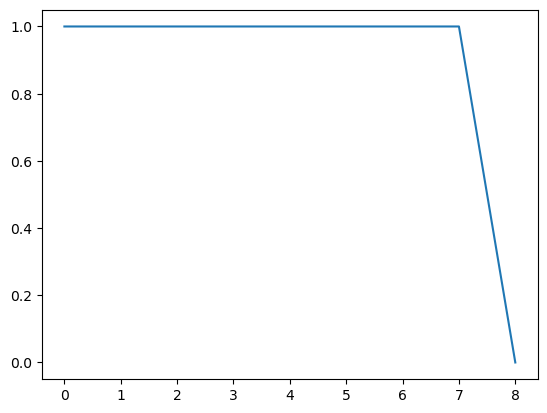

In [14]:
import matplotlib.pyplot as plt
plt.plot(np.sum(Hstr[:, group==3].todense(), axis=1))

In [35]:
from scipy.sparse import lil_matrix


def sfd(x, grad, Hstr, group, dx):
    xcurr = x.flatten()
    m, n = Hstr.shape
    v = np.zeros(n)
    ncol = np.max(group)

    alpha = 1e-6 * np.ones(ncol)

    H = lil_matrix(Hstr != 0, dtype=float)  # Equivalent of MATLAB's spones
    for k in range(ncol):
        d = (group == k + 1)
        y = xcurr + alpha[k] * d

        v = dx(y)
        w = (v - grad) / alpha[k]
        cols = np.where(d)[0]
        A = lil_matrix((m, n), dtype=float)
        A[:, cols] = H[:, cols]
        H[:, cols] -= A[:, cols]

        row, col = A.nonzero()
        A_new = lil_matrix((m, n), dtype=float)
        A_new[row, col] = w[row]
        H += A_new

    H = (H + H.T) / 2  # Make it symmetric
    return H


In [36]:
x0=(jax_energy.x**2-1)[1:-1].copy()


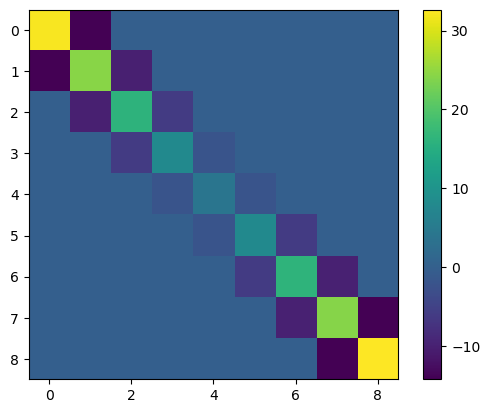

In [37]:
H = sfd(np.array(x0), df(x0), Hstr, group, df)
plt.imshow(H.todense())
plt.colorbar()
plt.show()

In [28]:
np.sqrt(np.finfo(float).eps)


1.4901161193847656e-08

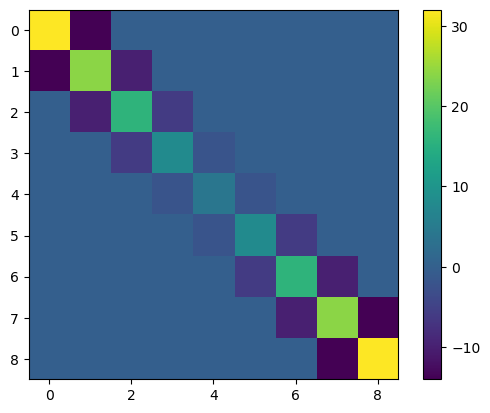

In [18]:
H_jax = ddf_cls(x0)
H_jax.H
plt.imshow(H_jax.H)
plt.colorbar()
plt.show()

In [44]:
from scipy.sparse import find


def sfd(x, grad, H, group, dx):
    xcurr = x.flatten()
    m, n = H.shape
    v = np.zeros(n)
    ncol = np.max(group)

    alpha = np.sqrt(np.finfo(float).eps) * np.ones(ncol)

    H = lil_matrix(H != 0)  # Equivalent of MATLAB's spones
    for k in range(ncol):
        d = (group == (k+1))
        xnrm = max(norm(xcurr[d]), 1)
        alpha[k] *= xnrm

        y = xcurr + alpha[k] * d
        x[:] = y

        v = dx(x)
        w = (v - grad) / alpha[k]
        cols = np.where(d)[0]
        A = lil_matrix((m, n))
        A[:, cols] = H[:, cols]
        H[:, cols] -= A[:, cols]

        rows, cols, vals = find(A)
        p = np.argsort(rows)
        vals = w[p]
        A = coo_matrix((vals, (rows, cols)), shape=(m, n)).tolil()
        H += A

    H = (H + H.T) / 2  # Make it symmetric
    return H


In [46]:
plt.plot(group==1)
plt.show()

In [36]:
plt.plot(df(x0))
plt.show()

In [47]:
plt.plot(group)
plt.show()